In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import json
from sklearn.metrics import accuracy_score, classification_report, f1_score

from datasets import load_dataset
from collections import Counter


torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#top 5 annotators, everything else is labelled 5
annotator_to_label = {'A7': 0, 'A5': 1, 'A9': 2, 'A6': 3, 'A10': 4}


def load_data():
    data = load_dataset("mila-ai4h/biasly-data", "biasly-data")
    data = data["train"]
    data_hash = {}
    
    non_majority_label_indexes = []

    import random
    random.seed(42)
    indices = list(range(10000))
    random.shuffle(indices)
    for i in indices:

    #add majority label here and remove those keys that don't have a majority label. 
        if (data[i*3]['is_misogynistic'] == "Unclear" or 
            data[i*3+1]['is_misogynistic'] == "Unclear" or 
            data[i*3+2]['is_misogynistic'] == "Unclear"):
            continue
        else:
            labels = [data[i*3]['is_misogynistic'],data[i*3+1]['is_misogynistic'],data[i*3+2]['is_misogynistic']]
            counter = Counter(labels)
            most_common_labels = counter.most_common()
            max_count = most_common_labels[0][1]
            
            # Get all labels with the max count (in case of a tie)
            majority_labels = [label for label, count in most_common_labels if count == max_count]
            data_hash[data[i*3]['datapoint_id']] = {
                'datapoint_id': data[i*3]['datapoint_id'], 
                'majority':  majority_labels[0],
                'text': data[i*3]['datapoint'],
                'annotators': [
                {'annotator_id': data[i*3]['annotator_id'], 'is_misogynistic': data[i*3]['is_misogynistic']},
                {'annotator_id': data[i*3+1]['annotator_id'], 'is_misogynistic': data[i*3+1]['is_misogynistic']},
                {'annotator_id': data[i*3+2]['annotator_id'], 'is_misogynistic': data[i*3+2]['is_misogynistic']}
            ]
            }
    
    return data_hash
data_hash = load_data()


# Load the HateXplain dataset
def load_hatexplain():
    data = load_data()
    
    train_texts, train_labels, train_annotators, val_texts, val_labels, val_annotators, test_texts, test_labels, test_annotators = [], [], [], [], [], [], [], [], []
    label_map = {"Yes": 1, "No": 0}

    train_data = dict(list(data_hash.items())[:7935])      # First 7935 elements
    val_data = dict(list(data_hash.items())[7935:8935])     # Next 1000 elements
    test_data = dict(list(data_hash.items())[8935:])        # Last 1000 elements
    
    for key, value in train_data.items(): #repeat everything 3 times. 
        train_texts.append(value['text'])
        train_labels.append(label_map[value["annotators"][0]["is_misogynistic"]])
        train_texts.append(value['text'])
        train_labels.append(label_map[value["annotators"][1]["is_misogynistic"]])
        train_texts.append(value['text'])
        train_labels.append(label_map[value["annotators"][2]["is_misogynistic"]])

        train_annotators.append(value["annotators"][0]["annotator_id"])
        train_annotators.append(value["annotators"][1]["annotator_id"])
        train_annotators.append(value["annotators"][2]["annotator_id"])
    for key, value in val_data.items():
        val_texts.append(value['text'])
        val_labels.append(label_map[value["annotators"][0]["is_misogynistic"]])
        val_texts.append(value['text'])
        val_labels.append(label_map[value["annotators"][1]["is_misogynistic"]])
        val_texts.append(value['text'])
        val_labels.append(label_map[value["annotators"][2]["is_misogynistic"]])
        
        val_annotators.append(value["annotators"][0]["annotator_id"])
        val_annotators.append(value["annotators"][1]["annotator_id"])
        val_annotators.append(value["annotators"][2]["annotator_id"])                              
    for key, value in test_data.items():
        test_texts.append(value['text'])
        test_labels.append(label_map[value["annotators"][0]["is_misogynistic"]])
        test_texts.append(value['text'])
        test_labels.append(label_map[value["annotators"][1]["is_misogynistic"]])
        test_texts.append(value['text'])
        test_labels.append(label_map[value["annotators"][2]["is_misogynistic"]])   
        
        test_annotators.append(value["annotators"][0]["annotator_id"])
        test_annotators.append(value["annotators"][1]["annotator_id"])
        test_annotators.append(value["annotators"][2]["annotator_id"])                                 
    return train_texts, train_labels, train_annotators, val_texts, val_labels, val_annotators, test_texts, test_labels, test_annotators

    
# Custom PyTorch dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, annotators, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.annotators = annotators

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            "label: {}".format(self.labels[idx]),
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        if self.annotators[idx] in annotator_to_label.keys():
            new_label = annotator_to_label[self.annotators[idx]]
        else: 
            new_label = 5
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(new_label, dtype=torch.long)
        }
train_texts, train_labels, train_annotators, val_texts, val_labels, val_annotators, test_texts, test_labels, test_annotators = load_hatexplain()


# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create PyTorch datasets
train_dataset = HateSpeechDataset(train_texts, train_annotators, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_annotators, val_labels, tokenizer)
test_dataset = HateSpeechDataset(test_texts, test_annotators, test_labels, tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/Users/nubster/miniconda3/envs/comp550-final-project/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [ ]:

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.to(device)

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm

# Training loop with progress bar, accuracy, and F1-score
def train_model(model, train_loader, val_loader, epochs=3, save_dir="saved_models"):
    best_val_acc = 0  # Track highest validation accuracy
    best_model_path = None
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress_bar:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            # Compute training loss and accuracy
            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for F1-score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        # Compute metrics
        train_acc = correct / total
        train_f1 = f1_score(all_labels, all_preds, average='macro')

        # Validation evaluation
        val_acc, val_f1 = evaluate(model, val_loader)

        # Save model for this epoch
        model_path = os.path.join(save_dir, f"biasly_ann_model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_path)
        
        # Track the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = model_path  # Save best model path

        print(f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"Best model saved at {best_model_path} with Val Acc: {best_val_acc:.4f}")
    last_model_path = os.path.join(save_dir, f"biasly_ann_model_epoch_{epochs}.pt")
    return best_model_path, last_model_path


# Evaluation function with accuracy and F1-score
def evaluate(model, data_loader, final=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            # print(tokenizer.decode(input_ids[0])) to check if it's in order
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    if final:
        print("\nFinal Test Classification Report:\n", classification_report(all_labels, all_preds))

    return accuracy, macro_f1

# Train the model
best_model_path, last_model_path = train_model(model, train_loader, val_loader, epochs=3)


# Evaluate on test set after training best model
print("\nFinal evaluation on test set best model:")
model.load_state_dict(torch.load(best_model_path))
test_acc, test_f1 = evaluate(model, test_loader, final=True)
print(f"Test Accuracy: {test_acc:.4f}, Test Macro F1-score: {test_f1:.4f}")

# Evaluate on test set after training last model
print("\nFinal evaluation on test set last model:")
model.load_state_dict(torch.load(last_model_path))
test_acc, test_f1 = evaluate(model, test_loader, final=True)
print(f"Test Accuracy: {test_acc:.4f}, Test Macro F1-score: {test_f1:.4f}")


In [56]:
len(data_hash.keys())

9935

In [44]:
count_no_majority = sum(1 for entry in data_hash.values() if entry['majority'] == "No")
print(count_no_majority)


8293


In [58]:
len(dict(list(data_hash.items())[7935:8935]) )

1000

In [12]:
ds["train"][0]

{'Unnamed: 0': 0,
 'datapoint_id': '9dd77afa-dfc8-4adb-87b2-b51f72ccc5fc',
 'datapoint': "ititmeansthatit's whatdoesthatmean? ititmeansthatit's really hard to find out where ititmeansthatit's really hard to find out where she was chatting from. Really hard to find out where she was chatting from.",
 'is_misogynistic': 'No',
 'why_unclear': None,
 'misogynistic_inferences': None,
 'other_inferences': None,
 'inferences_explanation': None,
 'original_severity': None,
 'rewrite_possible': None,
 'rewrite': None,
 'rewrite_severity': None,
 'annotator_id': 'A1',
 'annotator_background': 'Linguistics'}

In [ ]:
# 80/10/10 split 
# mum input sequence length of 512, batch size of 32, a learning rate of 2e-5, and 3 epochs for training.
# Can put datapoint id in a 

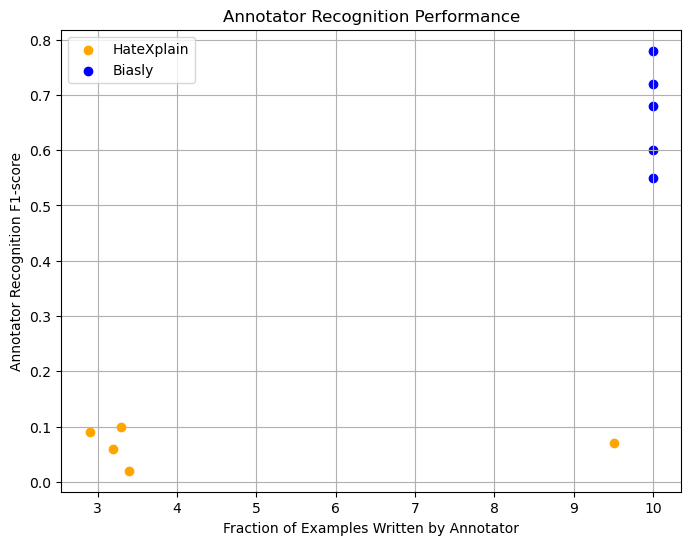

In [11]:
import matplotlib.pyplot as plt

# Sample data (replace with actual values)
hatexplain_fraction = [9.5, 3.4, 3.3, 3.2, 2.9]
hatexplain_f1 = [0.07, 0.02, 0.1, 0.06, 0.09]

biasly_fraction = [10,10,10,10,10]
biasly_f1 = [0.55, 0.6, 0.68, 0.72, 0.78]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(hatexplain_fraction, hatexplain_f1, color='orange', label='HateXplain')
plt.scatter(biasly_fraction, biasly_f1, color='blue', label='Biasly')

# Labels and legend
plt.xlabel("Fraction of Examples Written by Annotator")
plt.ylabel("Annotator Recognition F1-score")
plt.title("Annotator Recognition Performance")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [8]:
train_dataset[20000]


{'input_ids': tensor([ 101, 2017, 1005, 2128, 2025, 6069, 2954, 1029, 2681, 2014, 2041, 1997,
         2009, 1012, 2017, 1998, 2033, 1012,  102, 3830, 1024, 1014,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [9]:
tokenizer.decode(train_dataset[20000]["input_ids"])


"[CLS] you're not gonna fight? leave her out of it. you and me. [SEP] label : 0 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [7]:
train_annotators[20000]

'A10'

In [10]:
train_labels[20000]

0